Epoch 1/5
1929/1929 - 8s - loss: 3.2970 - val_loss: 1.1152 - 8s/epoch - 4ms/step
Epoch 2/5
1929/1929 - 5s - loss: 1.0924 - val_loss: 1.1139 - 5s/epoch - 2ms/step
Epoch 3/5
1929/1929 - 5s - loss: 1.0515 - val_loss: 0.9514 - 5s/epoch - 2ms/step
Epoch 4/5
1929/1929 - 5s - loss: 1.0163 - val_loss: 1.0092 - 5s/epoch - 3ms/step
Epoch 5/5
1929/1929 - 5s - loss: 0.9825 - val_loss: 0.9069 - 5s/epoch - 3ms/step
1/1 [==============================] - 0s 19ms/step
                       Time  Predicted Temperature (C)
0 2016-12-31 23:00:00+00:00                   3.803977
1 2017-01-01 00:00:00+00:00                   3.054787
2 2017-01-01 01:00:00+00:00                   2.163118
3 2017-01-01 02:00:00+00:00                   1.303465
4 2017-01-01 03:00:00+00:00                   0.458024
5 2017-01-01 04:00:00+00:00                  -0.286206


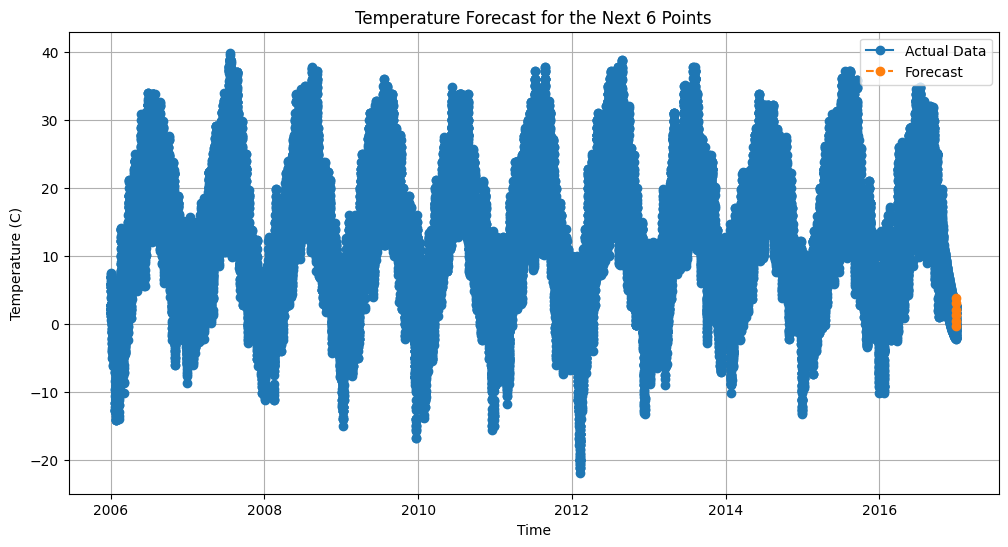

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow import keras
from tensorflow.keras import layers

# Load the dataset
df = pd.read_csv('D:/Airfield_weaather_prediction/data_prepration/temperature_data.csv')

# Convert the 'Formatted Date' column to datetime format
df['Formatted Date'] = pd.to_datetime(df['Formatted Date'], utc=True)

# Sort the DataFrame based on the 'Formatted Date' column
df = df.sort_values('Formatted Date')

# Create a time-based feature (e.g., hour of the day)
df['Hour'] = df['Formatted Date'].dt.hour

# Select relevant columns for modeling
data = df[['Formatted Date', 'Temperature (C)', 'Hour']]

# Create sequences for time series forecasting
sequence_length = 24  # Using 24 hours as one sequence
X, y = [], []

for i in range(len(data) - sequence_length):
    seq = data.iloc[i:i + sequence_length]
    X.append(seq[['Temperature (C)', 'Hour']].values)
    y.append(data.iloc[i + sequence_length]['Temperature (C)'])

X, y = np.array(X), np.array(y)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Build the RNN model
model = keras.Sequential([
    layers.SimpleRNN(50, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])),
    layers.Dense(1)
])

model.compile(optimizer='adam', loss='mse')

# Train the model
model.fit(X_train, y_train, epochs=5, batch_size=32, validation_split=0.2, verbose=2)

# Get user input for the number of points to predict
num_points_to_predict = int(input("Enter the number of points to predict: "))

# Initialize an array for predictions
forecasted_temperatures = []

# Create the initial input sequence for forecasting
last_sequence = X_test[-1]

# Generate forecasts for the specified number of points
for _ in range(num_points_to_predict):
    # Predict the next temperature
    next_temperature = model.predict(last_sequence.reshape(1, sequence_length, 2))[0][0]

    # Update the sequence with the predicted temperature and the current hour
    last_sequence = np.vstack([last_sequence[1:], np.array([next_temperature, df['Hour'].iloc[-num_points_to_predict + _]])])

    # Store the predicted temperature
    forecasted_temperatures.append(next_temperature)

# Generate time points for the forecast
forecast_time_points = pd.date_range(df['Formatted Date'].max(), periods=num_points_to_predict + 1, freq='H')[1:]

# Create a DataFrame for the predicted values
predicted_df = pd.DataFrame({'Time': forecast_time_points, 'Predicted Temperature (C)': forecasted_temperatures})

# Print the predicted values
print(predicted_df)

# Visualize the results
plt.figure(figsize=(12, 6))
plt.plot(df['Formatted Date'], df['Temperature (C)'], label='Actual Data', linestyle='-', marker='o')
plt.plot(predicted_df['Time'], predicted_df['Predicted Temperature (C)'], label='Forecast', linestyle='--', marker='o')
plt.title(f'Temperature Forecast for the Next {num_points_to_predict} Points')
plt.xlabel('Time')
plt.ylabel('Temperature (C)')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
import joblib
# Save the model
model.save('D:/AF_scratch/nonscaledmodel/Temperature_model.h5')